# Requirements

In [3]:
import re
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from pyproj import Geod
from shapely.geometry import LineString
import seaborn as sns
import sddk
from pyproj import Proj, transform

import pyproj
from shapely.ops import transform

In [16]:
# global parameters for plots
plt.style.use("default")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

# Import datasets

In [85]:
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson", driver="GeoJSON")

In [132]:
pleiades_regions = pleiades_regions.to_crs(3035)
pleiades_regions_merged = pleiades_regions.unary_union
pleiades_regions_merged_buffer = pleiades_regions_merged.buffer(distance=5000)

In [133]:
type(pleiades_regions_merged_buffer)

shapely.geometry.multipolygon.MultiPolygon

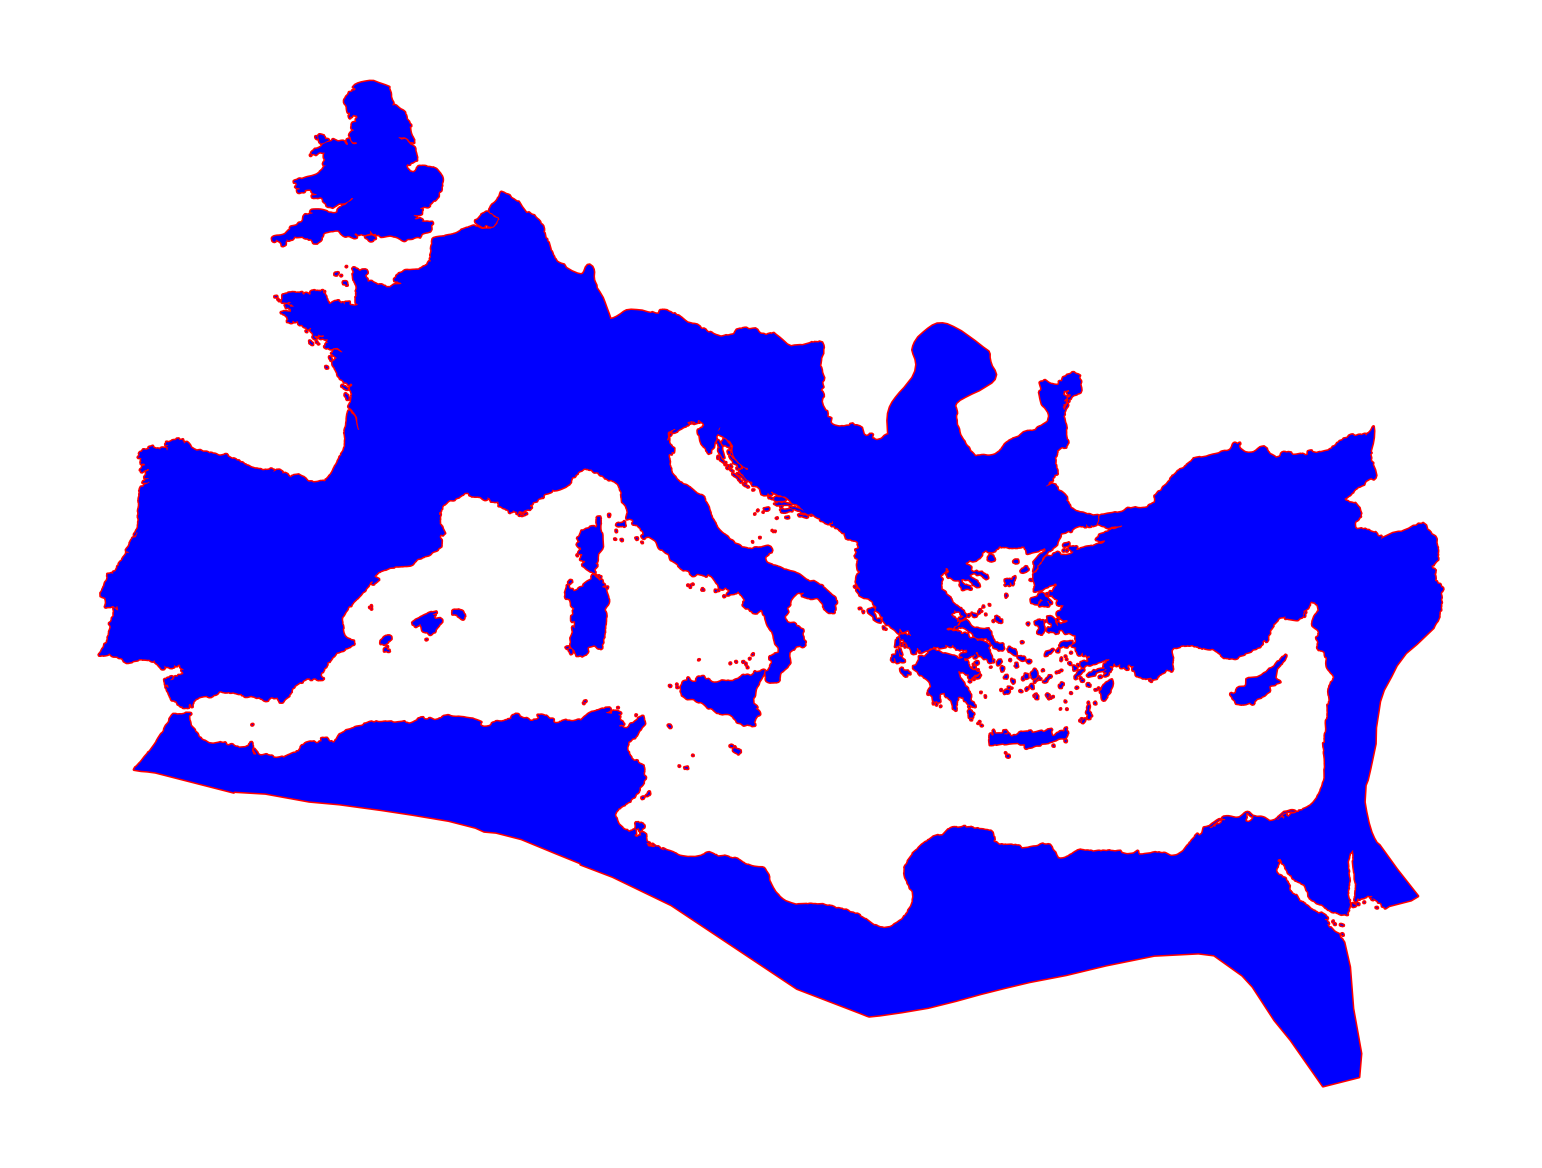

In [96]:
fig, ax = plt.subplots()
pleiades_regions_merged_buffer.plot(ax=ax, color="red")
pleiades_regions_merged.plot(ax=ax, color="blue")
ax.set_axis_off()

In [104]:
medsea = gpd.read_file("https://geo.vliz.be/geoserver/wfs?request=getfeature&service=wfs&version=1.1.0&typename=MarineRegions:iho&outputformat=json&filter=%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3COr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3314%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3315%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3322%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3324%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3346%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3351%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3363%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E3386%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E4279%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E%3CPropertyIsEqualTo%3E%3CPropertyName%3Emrgid%3C%2FPropertyName%3E%3CLiteral%3E4280%3C%2FLiteral%3E%3C%2FPropertyIsEqualTo%3E%3C%2FOr%3E", driver="GeoJSON")

In [105]:
medsea.to_file("../data/medsea.geojson", driver="GeoJSON")

In [136]:
medsea = medsea.to_crs(3035)
medsea_merged = medsea.unary_union
medsea_merged_buffer = medsea_merged.buffer(distance=5000)

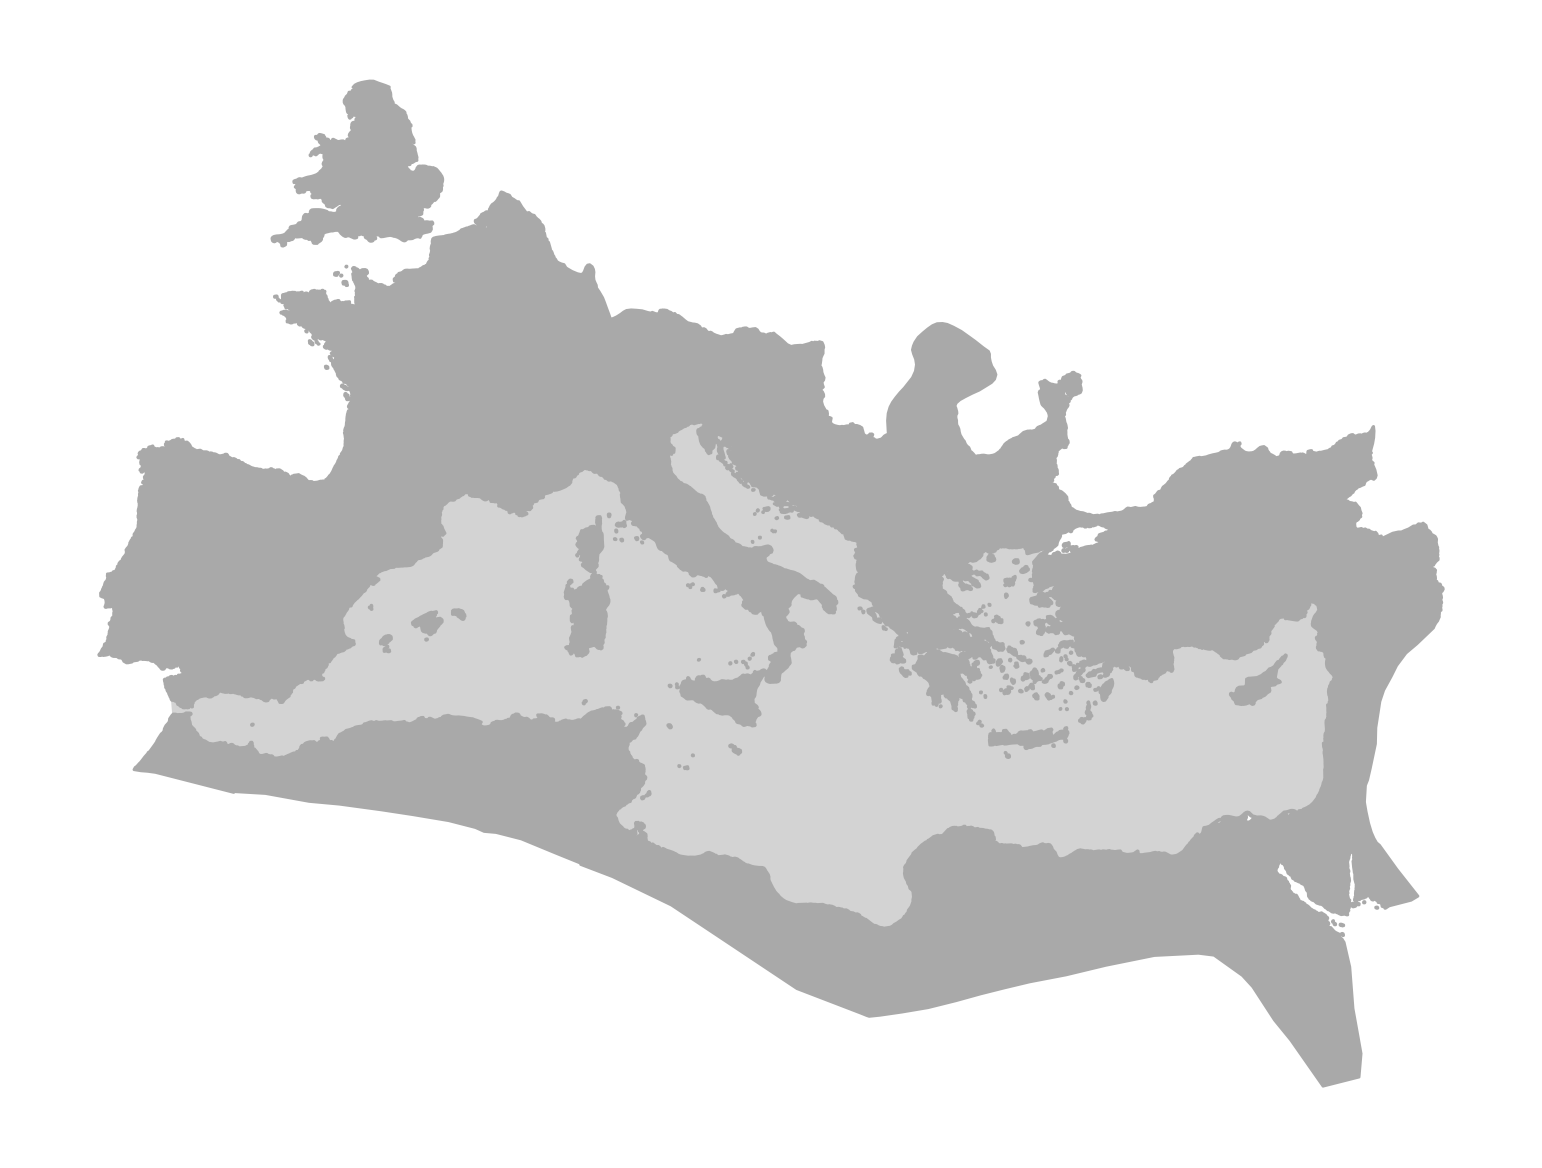

In [109]:
fig, ax = plt.subplots()
medsea_merged_buffer.plot(ax=ax, color="lightgrey")
pleiades_regions_merged_buffer.plot(ax=ax, color="darkgrey")
ax.set_axis_off()

In [110]:
GIST = gpd.read_parquet("../data/large_data/GIST_v0-1.parquet")

In [112]:
GIST = GIST.to_crs(3035)

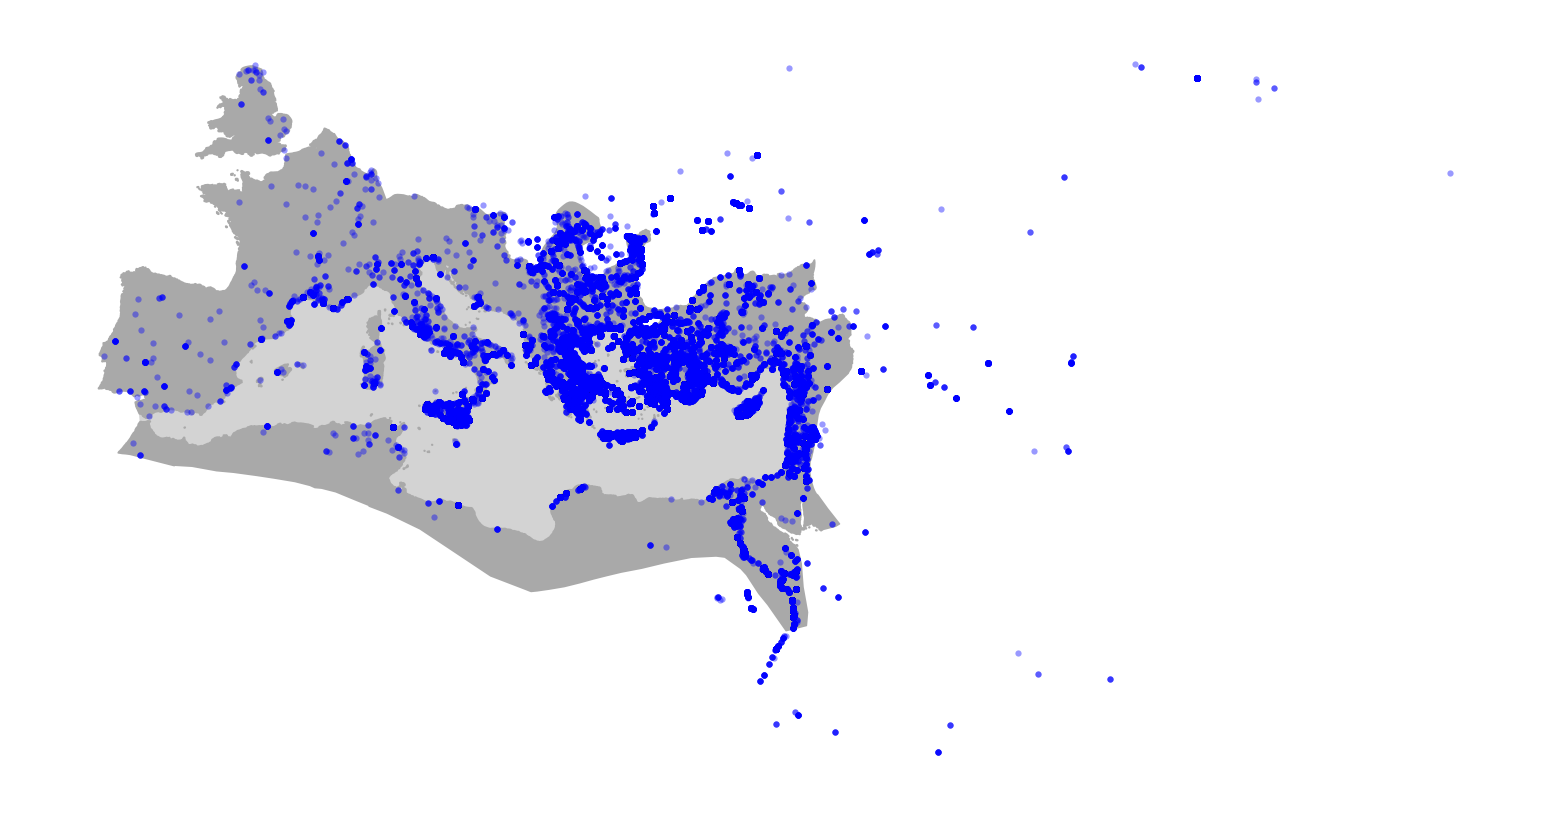

In [113]:
fig, ax = plt.subplots()
medsea_merged_buffer.plot(ax=ax, color="lightgrey")
pleiades_regions_merged_buffer.plot(ax=ax, color="darkgrey")
GIST.plot(ax=ax, marker=".", markersize=1, color="blue", zorder=3, alpha=0.4)
ax.set_axis_off()

In [59]:
# geocoded
len(GIST[GIST["x_long"].notnull()])

180061

In [135]:
len(GIST[GIST.within(pleiades_regions_merged_buffer)])

169812

In [138]:
%%time
len(GIST[GIST.within(pleiades_regions_merged)])

CPU times: user 7min 25s, sys: 6.57 s, total: 7min 31s
Wall time: 7min 32s


143750

In [139]:
len(GIST[GIST.within(medsea_merged_buffer)])

65166

In [55]:

GIST["date_type"].tolist()[0]["data"]

array(['range', 'phase', 'ca'], dtype=object)

In [56]:
for col in GIST.columns:
    if isinstance(GIST[col].tolist()[0], dict):
        GIST[col] = GIST[col].apply(lambda x: {"data" : list(x["data"])})

In [57]:
len(GIST)

217863

In [58]:
len(set(GIST["PHI_ID"].tolist()))

217863

In [76]:
# with some temporal and spatial info
GIRE = GIST[((GIST["not_after"].notnull()) | (GIST["not_before"].notnull())) & (GIST["x_long"].notnull())].copy()
len(GIRE)

106898

In [77]:
GIRE = GIRE[(GIRE["not_before"].between(-50, 350) | (GIRE["not_after"].between(-50, 350)))]
len(GIRE)

55641

In [52]:
%%time
GIRE = GIRE[GIRE.within(RE)].copy()
len(GIRE)

CPU times: user 2min 22s, sys: 1.62 s, total: 2min 23s
Wall time: 2min 24s


44313

(22.0, 55.5)

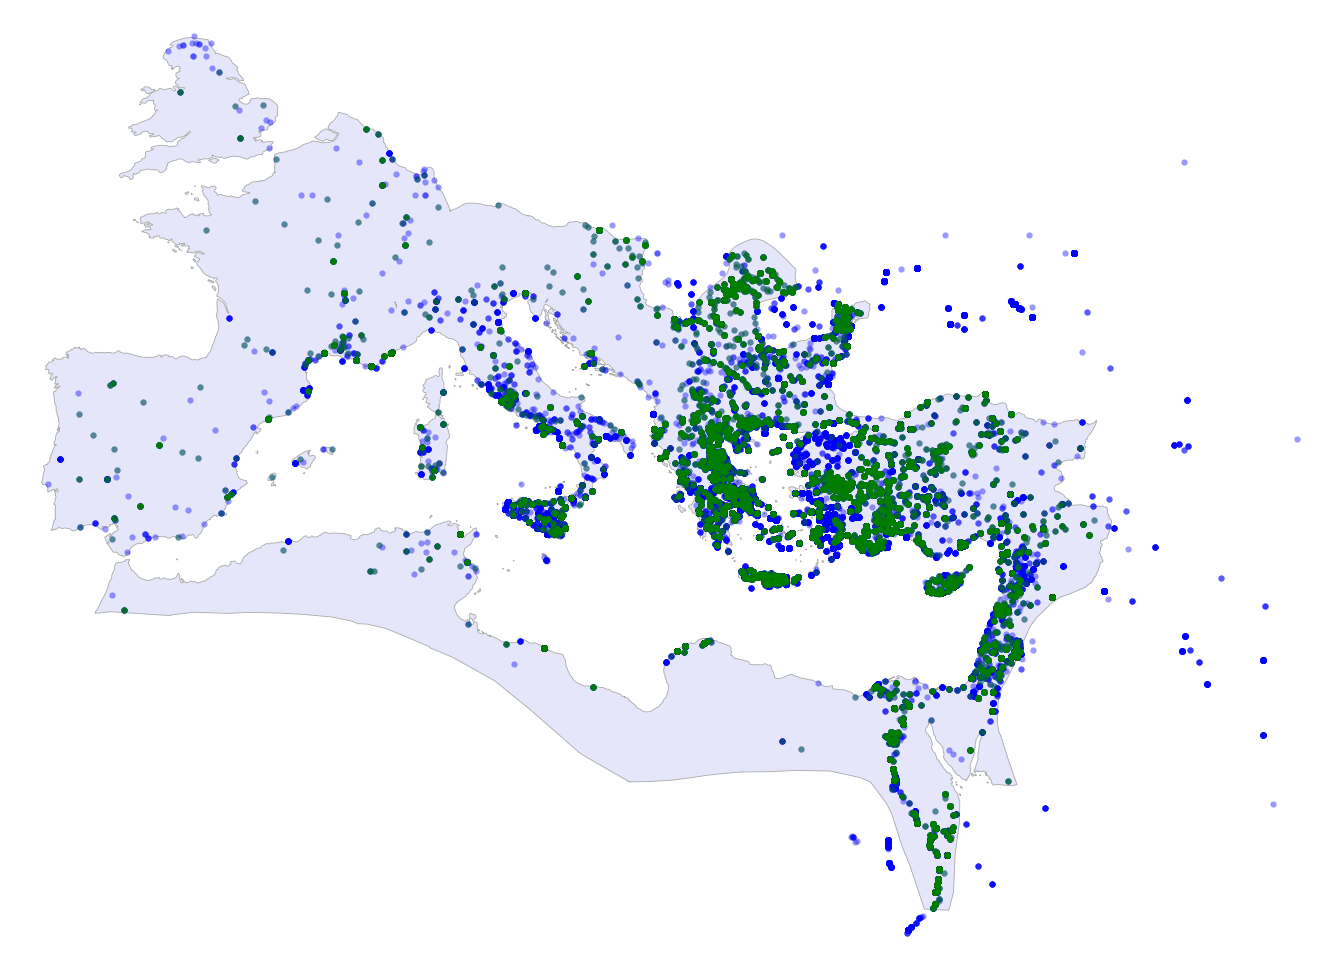

In [53]:
fig, ax = plt.subplots()
pleiades_regions_merged.plot(ax=ax, edgecolor="darkgrey" , linewidth=0.2, color="lavender")
#gplt.kdeplot(PHI[PHI["x_long"].notnull()], cmap=plt.get_cmap("Greens"), ax=ax, alpha=0.5, shade=True, zorder=2)
GIST.plot(ax=ax, marker=".", markersize=1, color="blue", zorder=3, alpha=0.4)
GIRE.plot(ax=ax, marker=".", markersize=1, color="green", zorder=3, alpha=0.4)
ax.set_axis_off()
ax.set_xlim(-10, 50)
ax.set_ylim(22, 55.5)
#ax.set_title(title + " (N={0})".format(str(len(subset))))

In [54]:
GIRE["GIRE_ID"] = range(1, len(GIRE)+1)

In [55]:
GIRE.set_index("GIRE_ID", inplace=True)

In [56]:
cols = ["geometry"]
cols_problematic = []
for col in GIRE.columns:
    try:
        GIRE[["geometry"] + [col]].to_file("../data/giretest.geojson")
    except:
        cols_problematic.append(col)

In [60]:
GIRE.to_file("../data/large_data/GIRE_v0.1.geojson", driver="GeoJSON")

In [61]:
GIRE.to_parquet("../data/large_data/GIRE_v0.1.parquet")